# Icentia11k Preprocessing

> Preprocessing steps for Icentia11k data for use in a multi-task classifier

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd

from ecg_classification.training import make_ecg_data_train_test_split, print_split_summary

In [2]:
plt.style.use("seaborn-v0_8-paper")

In [3]:
data = np.load(Path("../data/icentia11k/data.npz"))
data

NpzFile '../data/icentia11k/data.npz' with keys: signal, frame_num, beat, rhythm, patient...

## Missingness

Missing samples in a frame could cause issues in for our classifer, so we should check for that.
A quick check reveals there are no missing data in the inputs or the target labels.

In [4]:
def check_missingness_in_ecg_data(data: dict[str, npt.NDArray]) -> dict[str, float]:
    """Checks for missing data in ECG data. Returns a list of indices where there are missing data"""
    return {
        "signal": np.argwhere(np.isnan(data["signal"])),
        "rhythm": np.argwhere(np.isnan(data["rhythm"])),
        "beat": np.argwhere(np.isnan(data["beat"]))
    }

check_missingness_in_ecg_data(data)

{'signal': array([], shape=(0, 2), dtype=int64),
 'rhythm': array([], shape=(0, 1), dtype=int64),
 'beat': array([], shape=(0, 1), dtype=int64)}

## Train/Test Splits

In a nutshell, we want to design a model that will predict two different tasks: 1) identifying beat abnormalities and 2) identifying rhythm abnormalities.

We have good reason to believe there is some shared underlying structure between the two tasks because they both involve aspects of the same underlying ECG signal.

For a multi-task model, we want two different, but related, datasets:
1. Input ECG Signal, Beat labels
2. Input ECG Signal, Rhythm labels

but we want to make sure that the the input frames from one patient don't end up in both train and test because that might leak information the model wouldn't have access to.

To decide if we stratify-group-split by beat labels or by rhythm labels we should know which aspect would benefit more from the stratification. Because abnormal rhythm class is more rare, we should stratify by that to increase the chance that there is some abnormal rhythm examples in the test.

In [5]:
train, test = make_ecg_data_train_test_split(data, test_size=0.3, random_state=42)
print("Train:", train.X.shape)
print("Test:", test.X.shape)

Train: (31440, 800)
Test: (15720, 800)


## Addressing Class Imbalances

First, let's inspect the class imbalances in the training and test sets

In [6]:
print_split_summary(train)
print()
print_split_summary(test)

train split (31440, 800)
3525/31440 (0.1121) abnormal beats
34/31440 (0.0011) abnormal rhythms

test split (15720, 800)
46/15720 (0.0029) abnormal beats
277/15720 (0.0176) abnormal rhythms


There are many strategies to address class imbalances (refer to [Chapter 16 from Applied Predictive Modelling (Kuhn & Johnson, 2013)](https://vuquangnguyen2016.wordpress.com/wp-content/uploads/2018/03/applied-predictive-modeling-max-kuhn-kjell-johnson_1518.pdf))




Given the heavy class imbalance in the training set, it is appropriate to oversample.
But remember NOT to oversample in the test set!

Oversampling - [SMOTE](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)



## Visualizing the Data

As we apply preprocessing steps, it's important to visualize transformations of the signals.

Importantly, let's be sure to only inspect the training data.

In [7]:
from ecg_classification.visualize import plot_ecg, plot_multiple_ecg

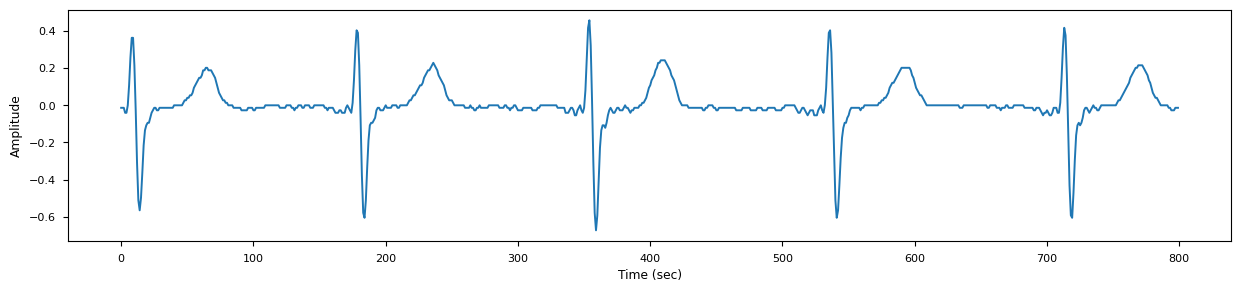

In [8]:
# Example of frame with normal beat and rhythm
plot_ecg(train.X[0]);

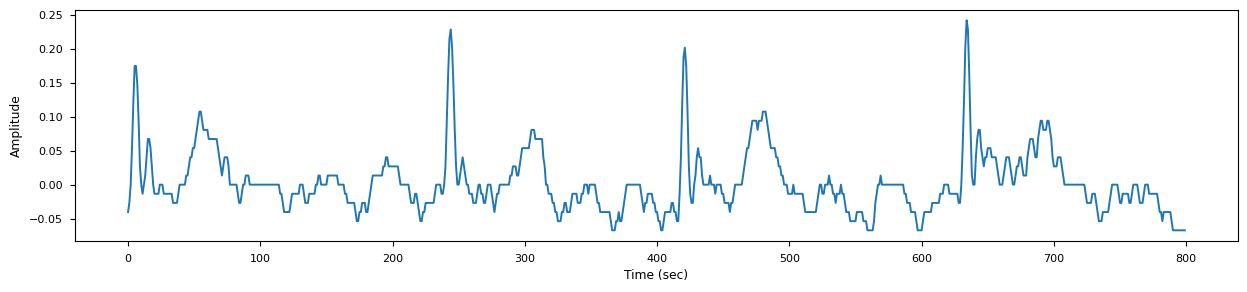

In [9]:
# Example of frame with abnormal rhythm
plot_ecg(train.X[np.argwhere(train.y_rhythm == 1)[0][0]]);

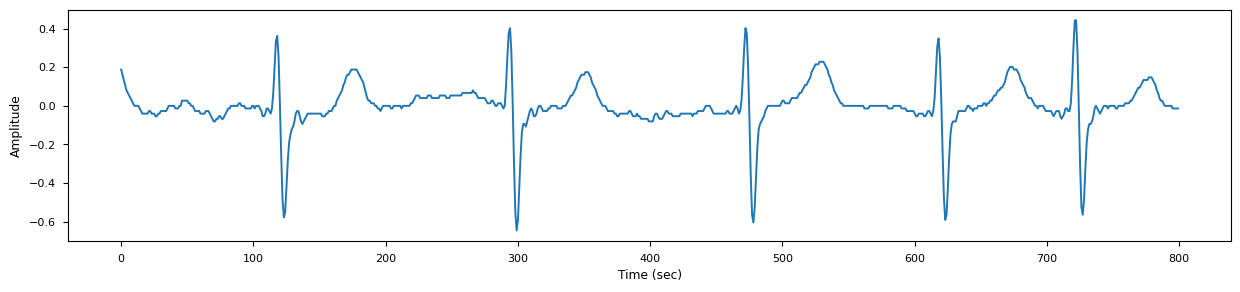

In [10]:
# Example of frame with abnormal beat
plot_ecg(train.X[np.argwhere(train.y_beat == 1)[0][0]]);

## Signal Pre-Processing

Based on the visuals above, it appears we should apply a few key preprocessing steps

1. Smooth (moving average filter)
2. Detrend
3. Normalize

More information here:

1. [Salimi et al. 2023](https://arxiv.org/pdf/2311.04229)
2. [https://www.dspguide.com/](https://www.dspguide.com/)

In [11]:
from ecg_classification.preprocessing import preprocess_ecg_signals
preprocessed_train = preprocess_ecg_signals(train.X)

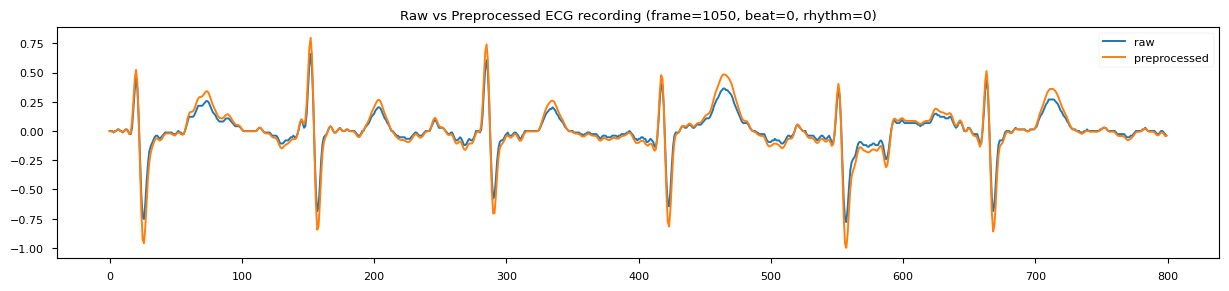

In [12]:
frame = 1050
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
time = np.arange(preprocessed_train.shape[1])
ax.plot(time, train.X[frame], label="raw")
ax.plot(time, preprocessed_train[frame], label="preprocessed")
ax.set_title(
    f"Raw vs Preprocessed ECG recording ({frame=}, beat={train.y_beat[frame]}, rhythm={train.y_rhythm[frame]})")
plt.legend()
plt.show()

## Cross-Validation

We must ensure that when performing cross-validation, we group by patient and stratify by class and preserve the temporal order of frames.

In other words, if we have $N$ patients in the training set, we train our model on $k$ patients and validate on $N - k$ patients, while ensuring the 

We (unrealistically) assume that segments of ECG signals are independent. This simplifying assumption is somewhat reasonable as Tan et al. 2019 derived segments by taking a random subset of ECG recording slices. We assume the segments were spaced out enough in time to not be correlated segments that occurred earlier in time.

Other approaches:
- [Mathworks: Classify ECG Signal](https://www.mathworks.com/help/signal/ug/classify-ecg-signals-using-long-short-term-memory-networks.html) - used random shuffling, because they had one 9000-sample long window of ECG signal for each patient. Bc each signal was from different patients, they were not temporally correlated.

## Evaluating Several Different Classifiers

### Implications for Modelling

[Calibrating a classifier - Scikit-Learn](https://scikit-learn.org/stable/modules/calibration.html#calibrating-a-classifier)